In [19]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 

In [20]:
import tensorflow as tf
import numpy as np
import math

In [21]:
((train_x, train_y),(eval_x, eval_y)) = tf.keras.datasets.mnist.load_data()
train_x = train_x/np.float32(255)
eval_x = eval_x/np.float32(255)

In [22]:
class HParams(object):
    def __init__(self, **kwargs):
        self.dict_ = kwargs
        self.__dict__.update(self.dict_)

    def update_config(self, in_string):
        pairs = in_string.split(",")
        pairs = [pair.split("=") for pair in pairs]
        for key, val in pairs:
            self.dict_[key] = type(self.dict_[key])(val)
        self.__dict__.update(self.dict_)
        return self

    def __getitem__(self, key):
        return self.dict_[key]

    def __setitem__(self, key, val):
        self.dict_[key] = val
        self.__dict__.update(self.dict_)


def get_default_hparams():
    return HParams(
        image_dim = 28,
        epoch_num = 50,
        batch_size = 1000,
        learning_rate = 1e-3,
        next_batch = 0)

In [23]:
def bottleneck_block_resnet164(inputs, input_filters=64, training=True, scope='bottleneck_block_resetnet164'):
    n_in = inputs.get_shape()[-1]
    with tf.variable_scope(scope):
        residual = inputs
        h = tf.keras.layers.BatchNormalization(h, training=True, scope="bn_1")
        h = tf.nn.relu(h)
        h = tf.layers.conv2d(inputs=inputs, filters=input_filters, kernel_size=[1,1], padding="same", scope="conv1")
        
        h = tf.keras.layers.BatchNormalization(h, training=True, scope="bn_2")
        h = tf.nn.relu(h)
        h = tf.layers.conv2d(inputs=h, filters=input_filters, kernel_size=[3,3], padding="same", scope="conv2")
        
        h = tf.keras.layers.BatchNormalization(h, training=True, scope="bn_3")
        h = tf.layers.conv2d(inputs=h, filters=input_filters*4, kernel_size=[1,1], padding="same", scope="conv3")
        
        if n_in != inputs_filters*4:
            shortcut = tf.layers.conv2d(inputs=inputs, filters=inputs_filters*4, kernel_size=[1,1], scope="conv4")
        else:
            shortcut = inputs
        return tf.nn.relu(shortcut + h)

In [24]:
def conv_pool(inputs, filters=32, kernel_size=[5,5], pool_size=[2,2]):
    conv = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding="same",
        activation=tf.nn.relu)
    pool = tf.layers.max_pooling2d(inputs=conv, pool_size=pool_size, strides=2)
    return pool

def dense_layer(inputs, reshape=(7,7,64), units=1024, drop_out=True, drop_out_rate=0.4, training=True):
    inputs = tf.reshape(inputs, [-1, reshape[0]*reshape[1]*reshape[2]])
    dense = tf.layers.dense(inputs=inputs, units=units, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=drop_out_rate, training=training)
    return dropout



In [25]:
def cnn_model(inputs, training=True):
    with tf.variable_scope("cnn_model", reuse=tf.AUTO_REUSE):
        inputs = tf.expand_dims(inputs, 3)
        conv1 = conv_pool(inputs)
        conv2 = conv_pool(conv1, filters=64)
        dense = dense_layer(conv2, training=training)
        logits = tf.layers.dense(inputs=dense, units=10)
    return logits

In [26]:
def get_batch(data, batch_num, batch_size=100):
    if batch_size == 0:
        raise ValueError("batch_size cannot be zero")
    elif batch_num < 0:
        raise ValueError("batch_num must be larger than or equal to zero")
    elif data is np.ndarray:
        raise TypeError("input data should be numpy.ndarray")
    elif data.shape[0] < batch_size:
        raise TypeError("please reduce the batch_size less than the data number")
    number_of_batch = data.shape[0]//batch_size
    if batch_num >= number_of_batch:
        end_of_batch = True
    else:
        end_of_batch = False
    batch_num = batch_num % number_of_batch
    return data[batch_num*batch_size:(batch_num+1)*batch_size], end_of_batch

In [103]:
def training(train_x, train_y, hps, 
             restore=False, save=False, clean_graph=False, 
             sess=tf.Session(), path="./trained_model", filename="model.ckpt"):
    inputs = tf.placeholder(tf.float32, shape=(None, hps.image_dim, hps.image_dim))
    labels = tf.placeholder(tf.int32, shape=(None))
    logits = cnn_model(inputs)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    optimizer = tf.train.AdamOptimizer(learning_rate=hps.learning_rate).minimize(loss)
    saver = tf.train.Saver()

    sess.run([tf.global_variables_initializer()])
    if restore:
        saver.restore(sess, "{0}/{1}".format(path, filename))

    for epoch in range(hps.epoch_num):
        next_batch = hps.next_batch
        while True:
            train_data, end_of_batch = get_batch(train_x, batch_size=hps.batch_size, batch_num=next_batch)
            train_labels, _ = get_batch(train_y, batch_size=hps.batch_size, batch_num=next_batch)
            next_batch += 1
            sess.run(optimizer, feed_dict={inputs: train_data, labels: train_labels})
            loss_run_time = sess.run(loss, feed_dict={inputs: train_data, labels: train_labels})
            if end_of_batch:
                break
        print("Epoch: {}, Loss:{}".format(epoch, loss_run_time))
    if save:
        save_path = saver.save(sess, "{0}/{1}".format(path, filename))
        print("Model is saved to {0}".format(save_path))
        

In [118]:
def evaluation(eval_x, eval_y, hps, 
               clean_graph=False, sess=tf.Session(),
               path="./trained_model", filename="model.ckpt"):
    inputs = tf.placeholder(tf.float32, shape=(None, hps.image_dim, hps.image_dim))
    labels = tf.placeholder(tf.int32, shape=(None))
    logits = cnn_model(inputs, training=False)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    saver = tf.train.Saver()
    sess.run([tf.global_variables_initializer()])
    saver.restore(sess, "./trained_model/model.ckpt")
    loss_run_time, logits_run_time = sess.run([loss, logits], feed_dict={inputs: eval_x, labels: eval_y})
    accuracy = 100 * np.sum(np.argmax(logits_run_time, axis=1) == eval_y) / eval_y.shape[0]
    print("Loss:{}, Accuracy:{}%".format(loss_run_time, accuracy))
    return logits_run_time, eval_y

In [111]:
def uniform_perturbation(sample, x_min, x_max, n=1, sigma=1, seed=0):
    import torch
    sample = torch.tensor(sample)
    prior = dist.Uniform(low=torch.max(sample-sigma, torch.tensor([x_min])), high=torch.min(sample+sigma, torch.tensor([x_max])))
    x = prior.sample(torch.Size([n]))
    return x.numpy()

In [112]:
def show_grey_scale_numpy_array(array):
    import matplotlib.pyplot as plt
    %matplotlib inline  
    imgplot = plt.imshow(array, cmap='gray')

In [113]:
# The bounds in NN-space
x_min = (0-0.1307)/0.3081
x_max = (1-0.1307)/0.3081

In [119]:
tf.reset_default_graph()
with tf.Session() as sess:
    logits, labels = evaluation(eval_x, eval_y, get_default_hparams(), clean_graph=True, sess=sess)

INFO:tensorflow:Restoring parameters from ./trained_model/model.ckpt
Loss:0.025718383491039276, Accuracy:99.35%


In [61]:
sample_idx = random.randrange(0, eval_x.shape[0])
sample_x, sample_y = eval_x[sample_idx], eval_y[sample_idx]

In [96]:
x_samples = uniform_perturbation(sample_x, x_min, x_max, sigma=0.1, n=100)

/home/deep_strive/anaconda3/envs/florence/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


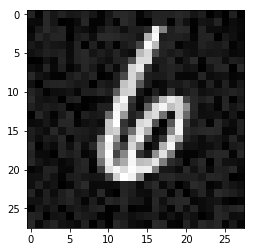

In [97]:
show_grey_scale_numpy_array(x_samples[0])

In [ ]:
def compute_property_function(logits, labels):
    labels_equal_argmax_logits = logits.argmax(axis=1) == labels
    correct_logits = np.array([logits[idx][label] for idx, label in enumerate(labels)]) 
    z_c = np.exp(correct_logits)/np.exp(logits).sum(axis=1)
    logits_rankings = np.argsort(logits, axis=1)
    best_logits_without_labels = np.array([logit[logits_ranking[-2]] if equal_to_label else logit[logits_ranking[-1]] 
                                           for logit, logits_ranking, equal_to_label in zip(logits, logits_rankings, labels_equal_argmax_logits)])
    z_i = np.exp(best_logits_without_labels)/np.exp(logits).sum(axis=1)
    return z_i - z_c

In [205]:
labels_equal_argmax_logits = logits.argmax(axis=1) == labels
correct_logits = np.array([logits[idx][label] for idx, label in enumerate(labels)]) 
z_c = np.exp(correct_logits)/np.exp(logits).sum(axis=1)
logits_rankings = np.argsort(logits, axis=1)
best_logits_without_labels = np.array([logit[logits_ranking[-2]] if equal_to_label else logit[logits_ranking[-1]] 
                                       for logit, logits_ranking, equal_to_label in zip(logits, logits_rankings, labels_equal_argmax_logits)])
z_i = np.exp(best_logits_without_labels)/np.exp(logits).sum(axis=1)
z_i - z_c

In [192]:
(correct_logits == best_logits_without_labels).sum()

974

In [189]:
best_logits_without_labels

array([-3.1284127, -4.6026106, -0.9940326, ...,  2.1528246, 13.913006 ,
       -3.6504607], dtype=float32)

In [188]:
np.sort(compute_property_function(logits, labels))[::-1][:100]

array([9.9883473e-01, 9.7974843e-01, 9.5625323e-01, 9.5526350e-01,
       9.3646300e-01, 7.2263104e-01, 6.3203639e-01, 4.4945332e-01,
       3.1172559e-01, 2.8178853e-01, 2.3306283e-01, 3.3422798e-06,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e

In [176]:
labels_equal_argmax_logits = logits.argmax(axis=1) == labels
correct_logits = np.array([logits[idx][label] for idx, label in enumerate(labels)]) 
z_c = np.exp(correct_logits)/np.exp(logits).sum(axis=1)
logits_ranking = np.argsort(logits, axis=1)
equal_to_labels = (logits_ranking[:, -1] == labels)
best_logits_without_labels = np.array([logit[-2] if equal_to_label else logit[-1] for logit, equal_to_label in zip(logits, equal_to_labels)])

In [178]:
logits[0]

array([-15.363265 ,  -8.789274 ,  -7.000543 ,  -4.8360305,  -7.425754 ,
        -6.2423096, -23.521011 ,  30.353163 ,  -3.1284127,   1.9631971],
      dtype=float32)

In [161]:
equal_to_labels = np.argsort(logits, axis=1)[:, -1] == labels

array([ True,  True,  True, ...,  True,  True,  True])

In [157]:
logits[0]

array([-15.363265 ,  -8.789274 ,  -7.000543 ,  -4.8360305,  -7.425754 ,
        -6.2423096, -23.521011 ,  30.353163 ,  -3.1284127,   1.9631971],
      dtype=float32)

In [156]:
np.argmax(logits, axis=1).shape

(10000,)

In [150]:
labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [145]:
labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [ ]:
mask = (np.arange(images.shape[0]) % 6) == labels

In [134]:
logits[0][]

array([-15.363265 ,  -8.789274 ,  -7.000543 ,  -4.8360305,  -7.425754 ,
        -6.2423096, -23.521011 ,  30.353163 ,  -3.1284127,   1.9631971],
      dtype=float32)

In [131]:
logits.argmax(axis=1) == labels

array([ True,  True,  True, ...,  True,  True,  True])

In [121]:
logits.argmax(axis=1)

array([7, 2, 1, ..., 4, 5, 6])

In [122]:
labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [125]:
np.exp(logits).sum(axis=1)

array([1.5212869e+13, 1.7668649e+16, 1.0827688e+08, ..., 7.6337154e+17,
       1.9872057e+15, 2.8427885e+13], dtype=float32)

In [126]:
np.maximum(np.exp(logits), axis=1)

ValueError: invalid number of arguments

In [140]:
correct_logits = np.array([logits[idx][label] for idx, label in enumerate(labels)]) 
z_c = np.exp(correct_logits)/np.exp(logits).sum(axis=1)

In [144]:
z_c[z_c != 1].shape

(2001,)

<h1> Below are Testing </h1>

In [ ]:
sample_quantile = 0.1
termination_threshold = math.exp(-250)
MH_steps = 100

In [ ]:
def mnist_perturbation

In [ ]:
def mnist_perturbation(inputs, mean=0, stddev=0.3, seed=0):
    perturbation = tf.random.normal(shape,mean=0.0,stddev=1.0,dtype=tf.dtypes.float32,seed=None,name="pertubation")
    return inputs

In [ ]:
def mnist_perturbation(data, mean=0, sd=0.3):
    perturbation = np.random.normal(loc=mean, scale=sd, size=data.shape)
    return data+perturbation

In [ ]:
mnist_perturbation(train_x)

In [7]:
import random
import scipy.stats

In [8]:
def proposal(x_prior=0):
    return scipy.stats.norm(x_prior,1).rvs()

In [9]:
def real_density(x):
    if x > 1 or x < 0:
        return 0
    else:
        return 1

In [10]:
def proposal_ratio(x, x_prior):
    x_prior_against_x = scipy.stats.norm(x,1).pdf(x_prior)
    x_against_x_prior = scipy.stats.norm(x_prior,1).pdf(x)
    return x_prior_against_x/x_against_x_prior

In [11]:
def real_density_ratio(x, x_prior):
    if x_prior < 0 or x_prior > 1:
        return 1e10
    else:
        return real_density(x)/real_density(x_prior)

In [12]:
M = 100000
x = proposal(3)
result = []
for i in range(M):
    result += [x]
    x_new = proposal(x)
    alpha = min(1, proposal_ratio(x_new, x)*real_density_ratio(x_new, x))
    u = random.random()
    if u < alpha:
        x = x_new
    else:
        pass

(array([4761., 4597., 4488., 4579., 4396., 4345., 4528., 4670., 4431.,
        4598., 4323., 4396., 4485., 4503., 4396., 4418., 4367., 4580.,
        4515., 4624.]),
 array([7.02345968e-05, 5.00656996e-02, 1.00061165e-01, 1.50056630e-01,
        2.00052095e-01, 2.50047560e-01, 3.00043025e-01, 3.50038490e-01,
        4.00033955e-01, 4.50029420e-01, 5.00024885e-01, 5.50020350e-01,
        6.00015815e-01, 6.50011280e-01, 7.00006745e-01, 7.50002210e-01,
        7.99997675e-01, 8.49993140e-01, 8.99988605e-01, 9.49984070e-01,
        9.99979535e-01]),
 <a list of 20 Patch objects>)

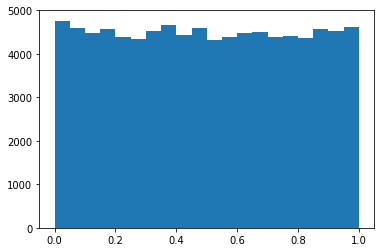

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.hist(result[10000:], bins=20)